# Chapter 7: Rock, Scissor and Paper: Multi-agent Simulation

### Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## 1-D Schelling Simulation

### Calculating the exponent

In [3]:
N = 300
OCCUPATE_RATE = 0.90
AB_RATIO = 1 # RATIO of A to B
ROUNDS = 1000

street = np.array([0 for _ in range(N)])
for idx, house in enumerate(street):
    if np.random.rand() < OCCUPATE_RATE:
        street[idx] = -1 if np.random.rand() < AB_RATIO/(1+AB_RATIO) else 1

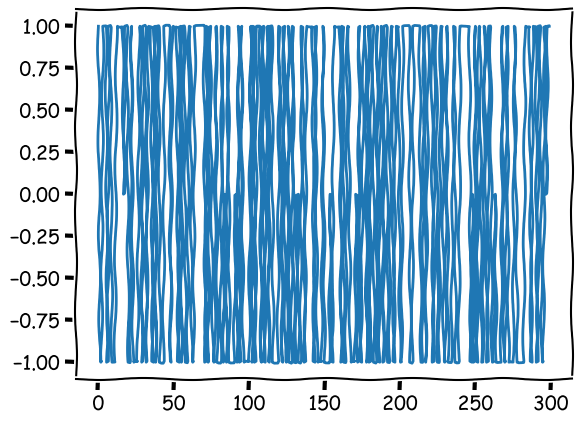

In [4]:
with plt.xkcd():
    plt.plot(street)

### Run simulation until no moves or exceeding maximal round

In [5]:
stable = False
iteration = 0

while not stable: #and iteration < ROUNDS:
    print("starting round {}".format(iteration))
    moves = 0
    # obtain the empty properties
    empties = set(i for i, house in enumerate(street) if house == 0)
    for idx, house in enumerate(street):
        if idx > 0 and idx < len(street)-1:
            if street[idx-1]*street[idx] == -1 or street[idx+1]*street[idx] == -1:
                # move to a random site
                target = np.random.choice(tuple(empties))
                empties.remove(target)
                empties.add(idx)
                street[target] = street[idx]
                street[idx] = 0
                moves += 1
    if moves == 0:
        break
    iteration += 1

starting round 0
starting round 1
starting round 2
starting round 3
starting round 4
starting round 5
starting round 6
starting round 7
starting round 8
starting round 9
starting round 10
starting round 11
starting round 12
starting round 13
starting round 14
starting round 15
starting round 16
starting round 17
starting round 18
starting round 19
starting round 20
starting round 21
starting round 22
starting round 23
starting round 24
starting round 25
starting round 26
starting round 27
starting round 28
starting round 29
starting round 30
starting round 31
starting round 32
starting round 33
starting round 34
starting round 35
starting round 36
starting round 37
starting round 38
starting round 39
starting round 40
starting round 41
starting round 42
starting round 43
starting round 44
starting round 45
starting round 46
starting round 47
starting round 48
starting round 49
starting round 50
starting round 51
starting round 52
starting round 53
starting round 54
starting round 55
st

### Plot the `stable` configuration

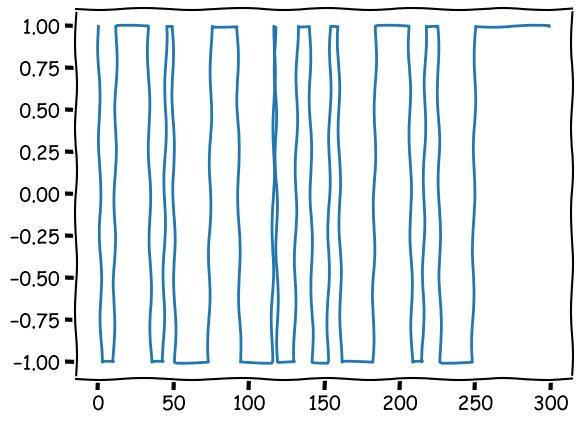

In [6]:
with plt.xkcd():
    plt.plot(street)

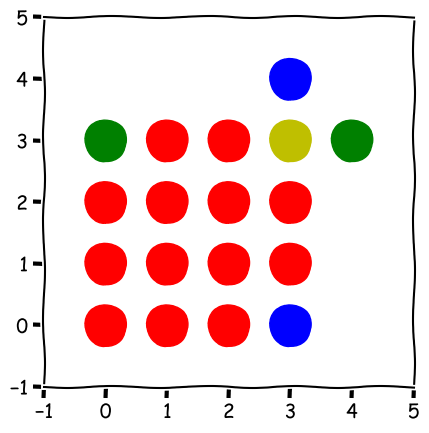

In [7]:
from itertools import product
x = y = [i for i in range(4)]
coordinates = product(x,y)
with plt.xkcd():
    plt.xlim(-1,5)
    plt.ylim(-1,5)
    for dot in coordinates:
        plt.plot(*dot,'ro', markersize=30) 
    plt.plot(3,4,'bo',markersize=30)
    plt.plot(3,0,'bo',markersize=30)
    plt.plot(4,3,'go',markersize=30)
    plt.plot(0,3,'go',markersize=30)
    plt.plot(3,3,'yo',markersize=30)
    plt.gca().set_aspect("equal")

## Mesa example

Import libraries and define some helpful classes.

In [8]:
from mesa import Model, Agent
from mesa.time import SimultaneousActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector

from enum import Enum
import random

class Type(Enum):
    STUBBORN = 1
    SNEAKY = 0
    
class Move(Enum):
    Scissors = 0
    Rock = 1
    Paper = -1
    
    def __lt__(self, other):
        if self == Move.Scissors and other == Move.Rock:
            return True
        if self == Move.Rock and other == Move.Paper:
            return True
        if self == Move.Paper and other == Move.Scissors:
            return True
        return False

### Package logics into game agents and contests class.

In [19]:
class GameAgent(Agent):

    def __init__(self, unique_id, pos, model, contestant_type):
        super().__init__(pos, model)
        self.unique_id = unique_id
        self.pos = pos
        self.contestant_type = contestant_type
        self.scores = []
        self.score = 0
        self.move = random.choice(list(Move))
        
    def step(self):
        
        self.score = 0
        # find all neighbors
        neighbors = [neighbor for neighbor in self.model.grid.neighbor_iter(self.pos)]
        neighbor_moves = [neighbor.move for neighbor in neighbors]
        self.score, winning_move = GameAgent.calculate_score(self.move, neighbor_moves)
        # determine next move based on current score
        if self.contestant_type == Type.STUBBORN:
            r = random.random()
            if r < 0.8:
                self.next_move = self.move
            else:
                moves = list(Move)
                moves.remove(self.move)
                self.next_move = random.choice(moves)
        else:
            # sneaky strategy
            if winning_move: 
                for move in list(Move):
                    if move > winning_move:
                        self.next_move = move
                        break
            else:
                self.next_move = random.choice(list(Move))
    
    def advance(self):
        self.scores.append(self.score)
        self.move = self.next_move
    
    @staticmethod
    def calculate_score(move, all_moves):
        # also return winning move
        
        if len(set(all_moves + [move])) == 3 or len(set(all_moves + [move])) == 1:
            # no winning move, it's a draw
            return 0, None
        
        win = all(move > other_move or move == other_move for other_move in all_moves)
        lose = all(move < other_move or move == other_move for other_move in all_moves)
        if win:
            return 1, move
        elif lose:
            return -1, random.choice(all_moves)
        return 0, None

In [20]:
class Contest(Model):

    def __init__(self, height=4, width=4, total_rounds = 100):

        self.height = height
        self.width = width
        self.total_rounds = total_rounds
        self.round = 0

        self.schedule = SimultaneousActivation(self)
        self.grid = SingleGrid(width, height, torus=True)
        
        self.datacollector = DataCollector(
            model_reporters={"stubborn_avg_score": lambda self: np.mean([np.mean(agent.scores) for 
                                                            agent in self.schedule.agents 
                                                            if agent.contestant_type == Type.STUBBORN]),
                             
                            "sneaky_avg_score": lambda self: np.mean([np.mean(agent.scores) for 
                                                            agent in self.schedule.agents 
                                                            if agent.contestant_type == Type.SNEAKY])},
        )

        for idx, cell in enumerate(self.grid.coord_iter()):
            x = cell[1]
            y = cell[2]
            if (x+y)%2 == 0:
                agent = GameAgent(idx, (x,y), self, Type.STUBBORN)
            else:     
                agent = GameAgent(idx, (x, y), self, Type.SNEAKY)
            self.grid.position_agent(agent, (x, y))
            self.schedule.add(agent)
        
        self.running = True

    def step(self):
        self.schedule.step()
        # collect data
        self.round += 1
        if self.round == self.total_rounds:
            self.running = False
        self.datacollector.collect(self)

In [21]:
model = Contest(4, 4, 100)

while model.running:
    model.step()

model.datacollector.get_model_vars_dataframe()

/Users/rongpengli/.local/share/virtualenvs/SWP_ASCII-sqcW_dxZ/lib/python3.10/site-packages/mesa/space.py:204: UserWarning: `neighbor_iter` is deprecated in favor of `iter_neighbors` and will be removed in the subsequent version.
  warn(


,stubborn_avg_score,sneaky_avg_score
0,0.000000,0.125000
1,-0.062500,0.250000
2,0.041667,0.125000
3,0.062500,0.031250
4,0.050000,0.025000
...,...,...
95,-0.044271,-0.027344
96,-0.042526,-0.028351
97,-0.040816,-0.028061
98,-0.040404,-0.031566


#### Check agent scores

In [23]:
model.schedule.agents[0].scores

[0,
 1,
 0,
 -1,
 -1,
 -1,
 0,
 1,
 0,
 0,
 -1,
 -1,
 -1,
 0,
 -1,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 -1,
 1,
 0,
 0,
 -1,
 -1,
 -1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 -1,
 0,
 -1,
 0,
 0,
 1,
 -1,
 -1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 -1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 -1,
 0,
 -1,
 1,
 0]